# Download required libs
import sys
!(sys.executable) -m textblob.download_corpora
%pip install NRCLex wordcloud transformers emoji

In [1]:
#from scipy.special import softmax
import pandas as pd
import datetime as dt
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
from transformers import pipeline, AutoTokenizer, AutoConfig, AutoModelForSequenceClassification
from lets_plot import *
from lets_plot.mapping import *

In [2]:
#importing the dataframes
posts_df = pd.read_csv("rkenya_posts.csv")
comments_df = pd.read_csv("rkenya_comments.csv")

In [3]:
#create a date and year column
posts_df["created_date"] = posts_df["created_utc"].apply(lambda x: dt.datetime.fromtimestamp(x))
posts_df["created_year"] = posts_df["created_date"].dt.year

In [4]:
#number of posts by year
LetsPlot.setup_html()
pyear = ggplot(posts_df,aes("created_year",fill="..count.."))+ \
    geom_bar(alpha=.7)+scale_fill_brewer(palette="Oranges")+\
    scale_fill_brewer(type='seq') + theme(panel_grid_major_x='blank')
pyear.to_html(path='pyears.html')
pyear.to_png(path='pyears.png',w=500,h=300,unit='cm', dpi=5)
pyear.show()

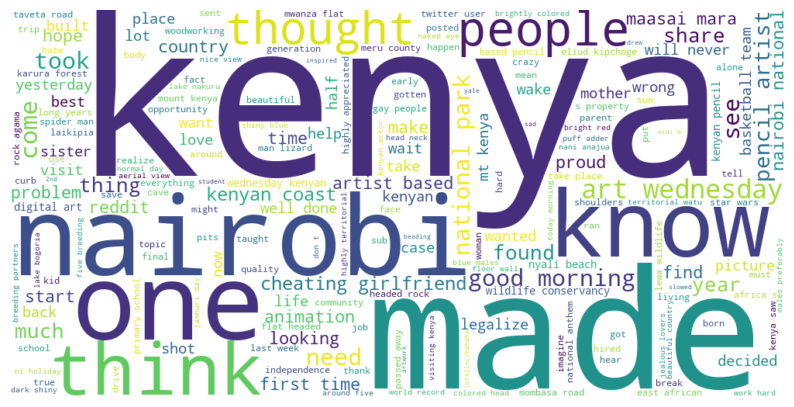

In [5]:
#create word cloud for word frequency
post_title_text = ''.join([title for title in posts_df["post_title"].str.lower()])
word_cloud = WordCloud(collocation_threshold=6,width=1000, height=500,
                       background_color= "white").generate(post_title_text)

plt.figure(figsize=(10,6))
plt.imshow(word_cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [6]:
#join the comments to the posts
commntPosts_df = posts_df.merge(comments_df, on = "post_id", how="left")

#define a regex pattern to match 
pattern = r"love"
comments_posts_df_sub = commntPosts_df[commntPosts_df["post_title"].str.contains(pattern)]

In [7]:
sentiment_classify = pipeline(model="cardiffnlp/twitter-roberta-base-sentiment-latest")

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [8]:
def get_sentiment(text):
    try:
        sentiment = sentiment_classify(text)[0]["label"]
    except:
        sentiment = "not classified"
    return sentiment

In [9]:
sentiments=comments_posts_df_sub["comment"].astype("str").apply(lambda x:get_sentiment(x))
comments_posts_df_sub.loc[:,"sentiment"] = sentiments

/tmp/ipykernel_14089/3008948823.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comments_posts_df_sub.loc[:,"sentiment"] = sentiments


In [10]:
psentiments = ggplot(comments_posts_df_sub) \
+ geom_pie(aes(fill=as_discrete("sentiment", order_by = "..count..")),
           size=30, hole=0.5,labels=layer_labels().
           line("@sentiment").line("(@{..prop..})").format("..prop..",".0%"))\
+theme(line=element_blank(), axis_text=element_blank(),axis_title=element_blank(),
       legend_position="none")\
+ggtitle("Sentiments on the topic")
psentiments.to_html(path='psentiments.html')
psentiments.to_png(path='psentiments.png',w=500,h=300,unit='cm', dpi=5)
psentiments.show()

In [11]:
emotion_classifier = pipeline(model = "bhadresh-savani/distilbert-base-uncased-emotion")

In [12]:
def get_emotions(text):
    try:
        emotion = emotion_classifier(text)[0]["label"]
    except:
        emotion = "not classified"
    return emotion

In [13]:
emotion=comments_posts_df_sub["comment"].astype("str").apply(lambda x:get_emotions(x))
comments_posts_df_sub.loc[:,"emotion"] = emotion

/tmp/ipykernel_14089/658328138.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comments_posts_df_sub.loc[:,"emotion"] = emotion


In [14]:
pemot = ggplot(comments_posts_df_sub) \
+geom_pie(aes(fill=as_discrete("emotion", order_by = "..count..")),
           size=30, hole=0.5,labels=layer_labels().
           line("@emotion").line("(@{..prop..})").format("..prop..",".0%"))\
+theme(line=element_blank(), axis_text=element_blank(),axis_title=element_blank(),
       legend_position='none')\
+ggtitle("Emotions around the topic")
pemot.to_html('pemotion.html')
pemot.to_png('pemotion.png',w=500,h=300,unit='cm', dpi=5)
pemot.show()